<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%load_ext autoreload 
%autoreload 2

import sys
import json
import re
import pandas as pd
import pickle
from numpy.testing import assert_allclose
from pathlib import Path

from dask.distributed import Client
from sklearn import set_config
# from macro_utils import load_datastore
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# internal
sys.path.append(r"/home/osindi/ami")
sys.path.append(r"/home/osindi/Symawofo")
sys.path.append(r"C:\Users\amoniri\PycharmProjects\Symawofo")
sys.path.append(r"C:\Users\amoniri\PycharmProjects\ami")

In [2]:
from symawofo import FeatureFrame, DataSplitter, WindowFrame, get_client
client = get_client('local')


In [3]:
df_master_daily = pd.read_csv('Transformed_Data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
df_master_weekly = df_master_daily[df_master_daily.index.weekday==4].copy() # Convert to weekly! Fridays (i.e. .resample('W-FRI').last())
df_master_weekly.tail()

UK_Equity_Vol  SEK_Equity_Vol  JPN_Nikkei_PE  US_Credit_IG_OAS  \
2020-06-26          26.89           27.14        27.4870          0.693702   
2020-07-03          23.02           24.31        27.2690          0.658068   
2020-07-10          23.60           23.92        27.2499          0.641216   
2020-07-17          21.56           22.09        27.7457          0.633169   
2020-07-24          21.74           22.02        27.8132          0.622158   

            US_Credit_HY_OAS  JPN_Credit_IG_OAS  EMU_Credit_IG_OAS  \
2020-06-26          6.153414           0.624857           0.754222   
2020-07-03          6.003799           0.623595           0.728486   
2020-07-10          5.967674           0.604368           0.726914   
2020-07-17          5.563074           0.608347           0.689635   
2020-07-24          5.042923           0.619334           0.640341   

            EMU_Credit_HY_OAS  UK_Credit_IG_OAS  UK_Credit_HY_OAS  ...  \
2020-06-26           5.316320          1.761242          6.900926  ...   
2020-07-03           5.225561          1.719609          6.835161  ...   
2020-07-10           5.249594          1.685940          6.926201  ...   
2020-07-17           5.072157          1.646381          6.825860  ...   
2020-07-24           4.816503          1.588846          6.715479  ...   

            EUR_CBEI_I_raw  EUR_CBBI_I_raw  JPY_CBEI_G_raw  JPY_CBBI_G_raw  \
2020-06-26        1.715546       34.878864       -0.528821       45.721187   
2020-07-03        1.715546       34.878864       -0.528821       45.721187   
2020-07-10        1.715546       34.878864       -0.528821       45.721187   
2020-07-17        1.715546       34.878864       -0.528821       45.721187   
2020-07-24        1.715546       34.878864       -0.528821       45.721187   

            JPY_CBEI_I_raw  JPY_CBBI_I_raw  USD_CBEI_G_raw  USD_CBBI_G_raw  \
2020-06-26       -1.588272       43.224932        1.298895       22.537034   
2020-07-03       -1.588272       43.224932        1.298895       22.537034   
2020-07-10       -1.588272       43.224932        1.298895       22.537034   
2020-07-17       -1.588272       43.224932        1.298895       22.537034   
2020-07-24       -1.588272       43.224932        1.298895       22.537034   

            USD_CBEI_I_raw  USD_CBBI_I_raw  
2020-06-26        0.878475       -7.529489  
2020-07-03        0.878475       -7.529489  
2020-07-10        0.878475       -7.529489  
2020-07-17        0.878475       -7.529489  
2020-07-24        0.878475       -7.529489  

[5 rows x 2860 columns]

In [4]:
from sklearn.base import BaseEstimator
from sklearn import set_config

from symawofo import make_pipeline, WindowFrame, DataSplitter, FeatureFrame, FeatureSeries
from symawofo.transformers import Lag, Difference, StandardScaler, TransformedTargetRegressor
from symawofo.model_selection.sk import GridSearchCV
from symawofo.models.base import model as model_dec, RegressorMixin2d
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.shared.utils import AssetType
from symawofo.metrics import make_scorer
from symawofo.pnl import PNL
# set_config(display='diagram')

In [155]:
@model_dec(RegressorMixin2d)
class SubStrat(BaseEstimator):
    def __init__(self, func=np.greater, thresh=0):
        self.func = func
        self.thresh = thresh
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return self.func(X, self.thresh)

def make_model(param_grid):
    scoring = make_scorer(lambda y, y_pred: np.mean(y_pred*y) - np.mean((1-y_pred)*y))

    my_model = GridSearchCV(SubStrat(lags=0), 
                            cv=5,
                            param_grid=param_grid, 
                            scoring=scoring)
    return my_model

In [243]:
my_feature_name = 'US_Equity'
my_target_name = 'US_Equity'

which = 1
if which == 0:
    param_grid = {'func': [np.less], 'thresh': [0]}
elif which == 1:
    param_grid = {'func': [np.greater, np.less], 'thresh': np.linspace(-1, 1, num=10)}
elif which == 2:
    param_grid = [{'func': [np.greater], 'thresh': np.linspace(0, 1, num=10)},
                  {'func': [np.less], 'thresh': np.linspace(-1, 0, num=10)}]

features = FeatureFrame(df_master_weekly[[my_feature_name]].copy().dropna())

target = FeatureFrame(df_master_weekly[[my_target_name]].copy().dropna()).squeeze()
target = make_pipeline(Difference(), Lag(-1)).fit_transform(target)

estimator = make_pipeline(
    Difference(),
    StandardScaler(),
    make_model(param_grid)
)

In [244]:
splitter = DataSplitter(
    test_size=100,
    initial_training_size=500,
    expanding=False,
    last_training_window=True
)

In [245]:
wf = WindowFrame(
    features=features,
    target=target,
    splitter=splitter,
    estimator=estimator
)
wf

Window(start=2000-01-07 00:00:00, end=2012-11-16 00:00:00)
Window(start=2003-04-18 00:00:00, end=2014-10-17 00:00:00)
Window(start=2005-03-18 00:00:00, end=2016-09-16 00:00:00)
Window(start=2007-02-16 00:00:00, end=2018-08-17 00:00:00)
Window(start=2009-01-16 00:00:00, end=2020-07-17 00:00:00)
Window(start=2010-12-17 00:00:00, end=2020-07-17 00:00:00)

In [246]:
wf.fit()

Monitor progress at http://127.0.0.1:8787/status


In [247]:
signal = ThresholdSignSignal(wf)
# my_signals = signal.get_signals()

strat_pnl = PNL(signal, asset_type=AssetType(level=False, log=True))

In [248]:
class LongOnly:
    def __init__(self, target, index):
        self.target = target
        self.index = index
    
    def get_signals(self):
        return pd.Series(np.ones(len(target)), index=target.data.index, dtype='float').reindex(self.index)

buyhold_pnl = PNL(LongOnly(target, my_signals.index), 
                  asset=target.data,
                  asset_type=AssetType(level=False, log=True))

Monitor progress at http://127.0.0.1:8787/status


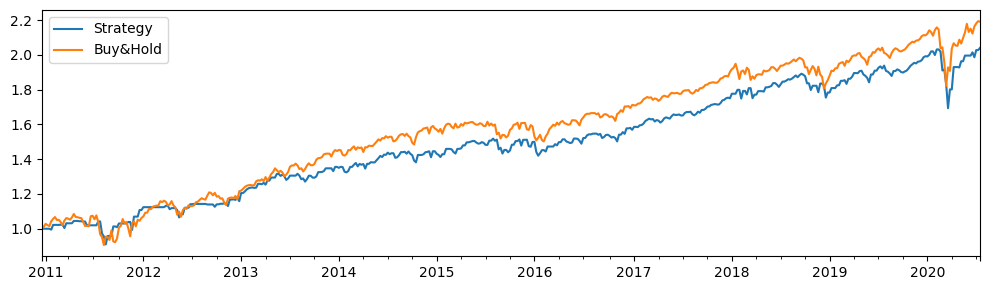

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=100)
strat_pnl.get_pnl().plot(label='Strategy')
buyhold_pnl.get_pnl().plot(label='Buy&Hold')
ax.legend()
plt.tight_layout()
plt.show()

In [250]:
for w in wf:
    print(w.estimator[-1].best_params_)

{'func': <ufunc 'less'>, 'thresh': -0.11111111111111116}
{'func': <ufunc 'less'>, 'thresh': 0.5555555555555554}
{'func': <ufunc 'less'>, 'thresh': 0.5555555555555554}
{'func': <ufunc 'less'>, 'thresh': 0.5555555555555554}
{'func': <ufunc 'less'>, 'thresh': 0.7777777777777777}
{'func': <ufunc 'less'>, 'thresh': 0.5555555555555554}


In [251]:
def return_stats(rets, name=None):
    if name: print(name)
    print(f'Average Return: {rets.mean()}')
    print(f'Volatility: {rets.std()}')
    print(f'Sharpe Ratio: {np.sqrt(52)*rets.mean()/rets.std()}')
    print('\n')

return_stats(buyhold_pnl.get_returns(), 'BUY&HOLD STRATEGY')
return_stats(strat_pnl.get_returns(), 'NEW STRATEGY')

BUY&HOLD STRATEGY
Average Return: 0.002135874512484839
Volatility: 0.022366484774811818
Sharpe Ratio: 0.6886200625851838


NEW STRATEGY
Average Return: 0.0018839928888838594
Volatility: 0.01999191305271547
Sharpe Ratio: 0.6795580738640342


